In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
image_path = []
labels = []

for i in os.listdir("dataset/animal_face_dataset"):
    for label in os.listdir(f"dataset/animal_face_dataset/{i}"):
        for image in os.listdir(f"dataset/animal_face_dataset/{i}/{label}"):
            image_path.append(f"dataset/animal_face_dataset/{i}/{label}/{image}")
            labels.append(label)

In [3]:
df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "label"])
df.head()

,image_path,label
0,dataset/animal_face_dataset/train/cat/flickr_c...,cat
1,dataset/animal_face_dataset/train/cat/pixabay_...,cat
2,dataset/animal_face_dataset/train/cat/pixabay_...,cat
3,dataset/animal_face_dataset/train/cat/pixabay_...,cat
4,dataset/animal_face_dataset/train/cat/pixabay_...,cat


In [4]:
df["label"].value_counts()

label
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64

In [5]:
train = df.sample(frac=0.7)
test = df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ]
)

In [7]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms
        self.labels = torch.tensor(label_encoder.transform(dataframe["label"])).to(
            device
        )

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image).to(device)

        return image, label

In [9]:
train_dataset = CustomImageDataset(dataframe=train, transforms=transform)
val_dataset = CustomImageDataset(dataframe=val, transforms=transform)
test_dataset = CustomImageDataset(dataframe=test, transforms=transform)

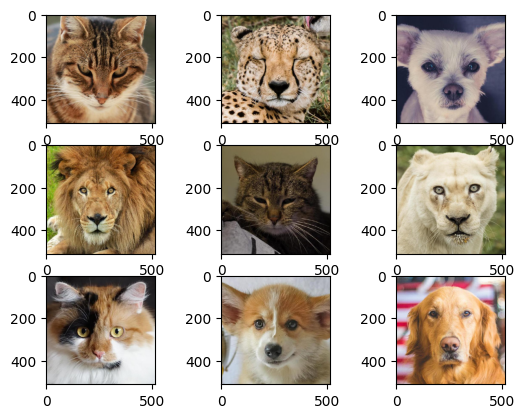

In [10]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)

plt.show()

In [11]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128 * 16 * 16), 128)
        self.output = nn.Linear(128, len(df["label"].unique()))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))
    total_acc_train_plot.append(
        round(total_acc_train / (train_dataset.__len__()) * 100, 4)
    )
    total_acc_validation_plot.append(
        round(total_acc_val / (val_dataset.__len__()) * 100, 4)
    )
    print(f"""Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(total_loss_train / 100, 4)} Train Accuracy {round((total_acc_train) / train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val / 100, 4)} Validation Accuracy: {round((total_acc_val) / val_dataset.__len__() * 100, 4)}""")
    print("=" * 25)

In [ ]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for input, label in test_loader:
        prediction = model(input)

        acc = (torch.argmax(prediction, axis=1) == label).sum().item()
        total_acc_test += acc
        test_loss = criterion(prediction, label)
        total_loss_test += test_loss.item()

    print(
        f"Accuracy Score is: {round((total_acc_test / test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test / 1000, 4)}"
    )

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    output = model(image.unsqueeze(0))
    output = torch.argmax(output, axis=1).item()
    return label_encoder.inverse_transform([output])


path = "dataset/test/cat.jpg"
## Visualize the image
image = Image.open(path)
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image(path)

In [ ]:
# Convert to TorchScript
scripted_model = torch.jit.script(model)
scripted_model.save("image_classifier.pt")